# History matching in sugarscape

A very brief description of sugarscape:
The environment grows sugar. The amount of sugar any location in the environment is capable of growing is in the range [0, 4].
Agents wander around harvesting sugar. The eat only what they need, and carry around any extra sugar they harvested.
After a location has been harvested, it regenerates its sugar by 1 each step in the simulation.
If there's not enough sugar in the agent's current location they try to move to a new location that has more sugar. They're limited in how far they can see and, therefore, how far they can move.
If they can't find enough sugar they die.


In [1]:
import numpy as np

from sugarscape_cg.model import SugarscapeCg

import history_matching
import sugarscape_hm
import plot_sugarscape_env

Plot the sugarscape environment. Each space in the grid as an amount of sugar ranging between 0 and 4. This is the maximum amount of sugar that given space can have at any time. The amount a space contains reduces as it is harvested, and grows back at a constant rate of 1 per time step in the simulation.

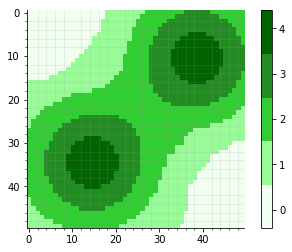

In [3]:
plot_sugarscape_env.plot()

## Exploring maximum metabolism

Create a function that takes the parameter(s) being tested and returns the output of interest.
In this example, we'll explore the effect of changing the agents maximum metabolism.
The higher an agent's metabolism, the more food they need to eat to survive.

The model will run for 50 steps as I found this was always sufficient to achieve a steady population state.

In [2]:
def run_simulation(x):
    SS = SugarscapeCg(max_metabolism=x)
    SS.verbose = False
    y =  SS.run_model(step_count=50)
    return y

We'll pretend one given run of the simulation is the "real world". In this case, the area was able to sustain a population of 64 agents.

Note, the initial population in the model is 100, and agents die if there is not enough food --- in fact, this is the only way they can die.

In [3]:
history_matching.y = 63  # the real world observation
history_matching.f = run_simulation  # the function (simulation) used for history matching

History matching involves multiple waves, each of which should (hopefully) narrow down the plausible space.
There are several different stopping criteria that can be chosen to define when the waves should stop.
Here, well use "history_matching.is_all_plausible", which checks if no new implausible spaces were found in the previous wave.

In [4]:
def run_history_matching(new_plaus_space):
    plaus_space = []  # not yet explored
    while not history_matching.is_all_plausible(plaus_space, new_plaus_space):
        plaus_space = new_plaus_space
        new_plaus_space, implaus_scores = history_matching.wave(plaus_space)
        sugarscape_hm.plot_implaus_1d(plaus_space, implaus_scores)
    print('Finished with', str(new_plaus_space))

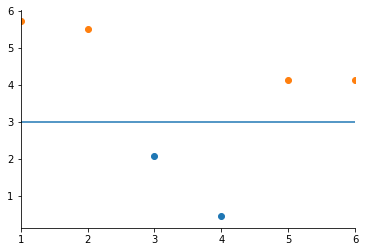

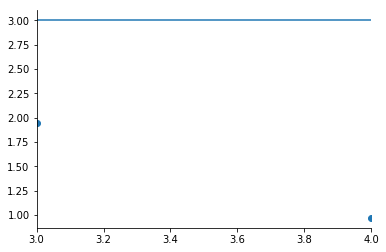

Finished with [3, 4]


In [5]:
# initial plausible space to explore
# note that SugarscapeCg only takes integer values for metabolism
plaus_space = np.array(range(1, 7))
run_history_matching(plaus_space)

We first tested maximum metabolisms in the range [1, 6]. The first wave shows values in the range [3,4] are plausible, and the rest are implausible.

In the second wave, we still find values in the range [3,4] are plausible.

As the plausible space is unchanged after the second wave, the procedure ends.

The "correct" result (used for the "real world" run) is 4.

## Exploring maximum vision

Next, let's explore the maximum vision; that is, how far the agent can see and therefore move. The further they can see, the more spaces with food they can explore and, therefore, the less likely they are to die. We'll have the maximum metabolism set at 4.

In [6]:
def run_simulation(x):
    SS = SugarscapeCg(max_vision=x)
    SS.verbose = False
    y =  SS.run_model(step_count=50)
    return y

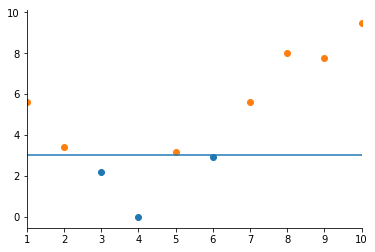

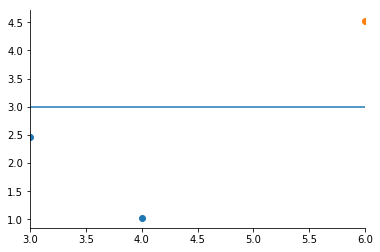

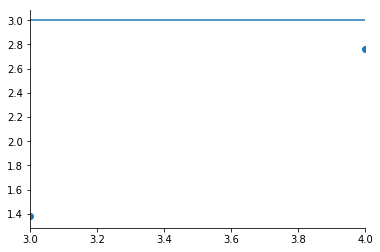

Finished with [3, 4]


In [7]:
# initial plausible space to explore
# note that SugarscapeCg only takes integer values for vision
plaus_space = np.array(range(1, 11))
run_history_matching(plaus_space)

In this case, maximum vision in the range [3, 6] (excluding 5) was found to be plausible in the first wave.

The range [3, 4] was found in the second wave.

The third wave also found [3, 4], so we end the procedure.

Interestingly, the maximum vision in the "real world" model was 6.

Note that this history matching example only considers uncertainty in the ensemble runs. As you add more uncertainty, the chance of a given parameter being plausible increases. Therefore, if we include other uncertainties, perhaps we may find 6 to be plausible.

## Notes

One thing of note, is that each time I run a procedure of waves, the results can differ. For example, sometimes the  max vision example stops with the plausible space [3, 4, 5], sometimes it stops with the space [3, 5], and on the above example it stopped with [3, 4]. I'm interested to know how people handle variability in the history matching results.

One thought (also mentioned above), is that the only uncertainty I'm quantifying, when considering if a given parameter is plausible, is variance across ensembles. However, it is common to include uncertainty in the model itself and in the observation (expected output) that you are comparing the simulation results against. If these uncertainties are modelled correctly, will there be less variability in the history matching results?

# History matching on two inputs simultaneously

Next, let's explore both metabolism and vision together.

In [8]:
from itertools import product
from time import strftime

from sugarscape_cg.model import SugarscapeCg

import history_matching
import sugarscape_hm

def run_simulation(x):
    SS = SugarscapeCg(max_metabolism=x[0], max_vision=x[1])
    SS.verbose = False
    y =  SS.run_model(step_count=50)
    return y

history_matching.y = 63
history_matching.f = run_simulation

Initially explore maximum metabolism in the range [2, 6] and maximum vision in the range [1, 10].
Continue waves until all of the space is considered plausible and plot the results. The maximum amount of food in any space is 4, so it is expected that a metabolism of 5 or 6 should become implausible because some agents will require more food than any given location can supply.

As an implausibility score greater than 3 is considered so implausible it is removed from the sample space, any scores higher are capped at 3 in the plot, for the sake of making the plot clearer.

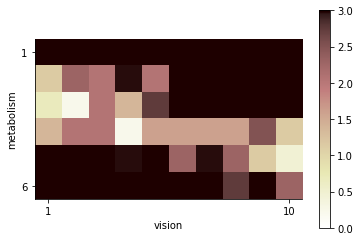

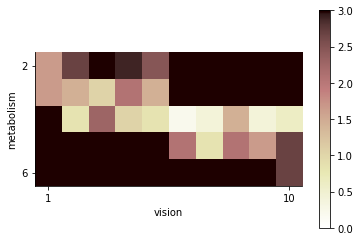

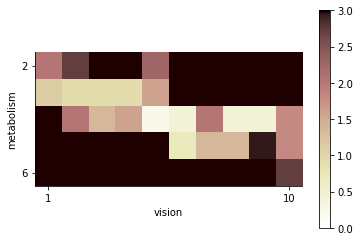

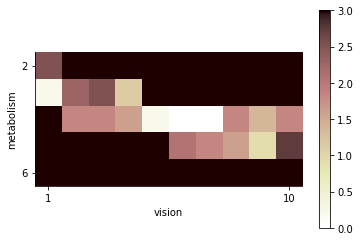

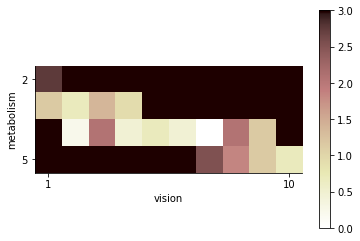

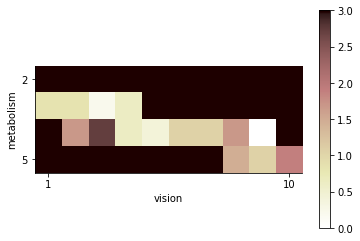

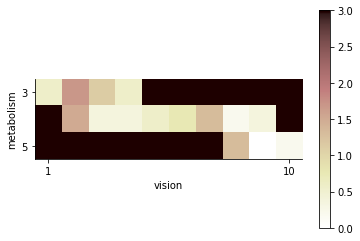

In [9]:
plaus_metabolism = range(1, 7)
plaus_vision = range(1, 11)
plaus_space = []  # not yet explored
new_plaus_space = list(product(plaus_metabolism, plaus_vision))

while not history_matching.is_all_plausible(plaus_space, new_plaus_space):
    plaus_space = new_plaus_space
    new_plaus_space, implaus_scores = history_matching.wave(plaus_space)
    sugarscape_hm.plot_implaus_2d(plaus_space, implaus_scores, ('vision','metabolism'))

Seven waves were carried out.
The plausible space for maximum metabolism started at [1, 6] and ended at [2, 5].
The plausible space of maximum vision remained at [1, 10] throughout.
This suggests that the model output may be less sensitive to maximum vision than to maximum metabolism - particularly where max metabolism is 4.

The final results appear to show a correlation between the two parameters. As the agents' maximum possible metabolism increases, their maximum vision must also increase. This seems intuitive as a higher metabolism means the agents will exhaust their nearby food supply quickly and so they will need long distance vision to be able find new (further away) locations that have enough food to survive.


## Does changing the environment lead to the same results

In this example, I've reduced the size of the environment from 50x50 to 30x30. The layout of the environemnt has been changed such that only half the amount of sugar is available compared to previously. However, there are also no "badlands" in this example. That is, in the previous example, there were spaces in the environment where no sugar grew. In this example, all spaces grow some sugar.

Using the default maximum metabolism (4) and maximum vision (6), the average number of agents the environment can sustain is 67 (interestingly, this is fairly unchanged compared to the previous example at 63).

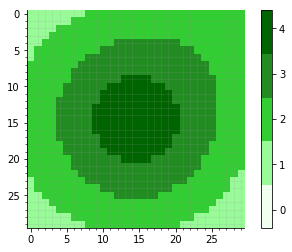

In [4]:
import plot_sugarscape_env
plot_sugarscape_env.plot('sugarscape_cg/sugar-map_small.txt')

In [1]:
from itertools import product
from time import strftime

from sugarscape_cg.model import SugarscapeCg

import history_matching
import sugarscape_hm

def run_simulation(x):
    SS = SugarscapeCg(height=30, width=30, max_metabolism=x[0], max_vision=x[1])
    SS.verbose = False
    y =  SS.run_model(step_count=50)
    return y

history_matching.y = 67
history_matching.f = run_simulation

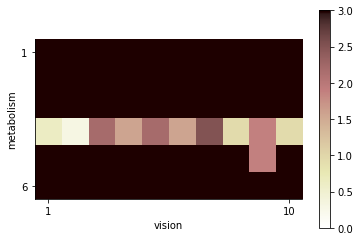

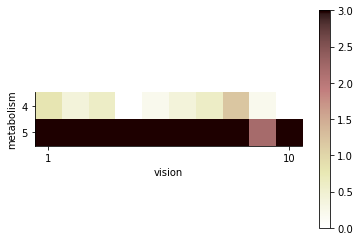

In [2]:
plaus_metabolism = range(1, 7)
plaus_vision = range(1, 11)
plaus_space = []  # not yet explored
new_plaus_space = list(product(plaus_metabolism, plaus_vision))

while not history_matching.is_all_plausible(plaus_space, new_plaus_space):
    plaus_space = new_plaus_space
    new_plaus_space, implaus_scores = history_matching.wave(plaus_space)
    sugarscape_hm.plot_implaus_2d(plaus_space, implaus_scores, ('vision','metabolism'))

The history matching procedure has converged onto the correct maximum metabolism (4) immediately. There is only one case in which a metabolism of 5 was considered plausible. The space of maximum vision has not been reduced, which suggests it may have less of an effect on the model.

In this next example, I've increased the size of the environment to 75x50 to see if the results change.
Once again, the model sustained a population of 67.

It would seem that the size of the environment does not have a great effect on the total agents that can survive. I suspect that, instead, the diameter of the regions with lots of sugar might have more of an effect. Also, putting the regions heavy with sugar closer together may have an effect.

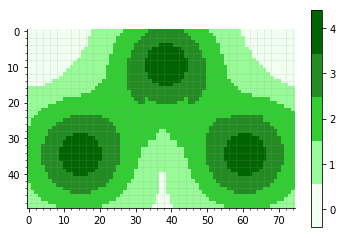

In [5]:
import plot_sugarscape_env
plot_sugarscape_env.plot('sugarscape_cg/sugar-map_large.txt')

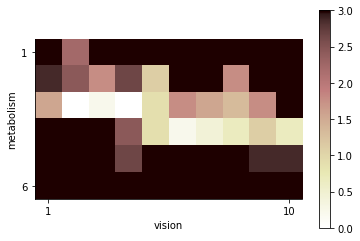

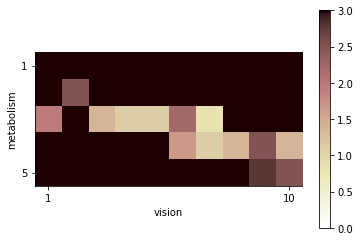

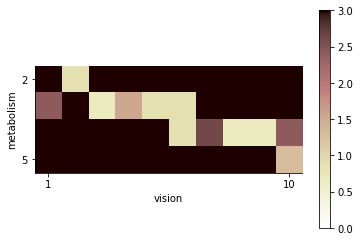

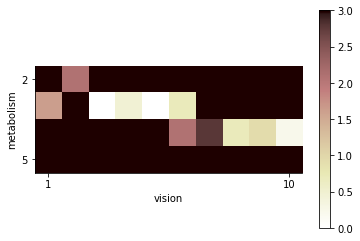

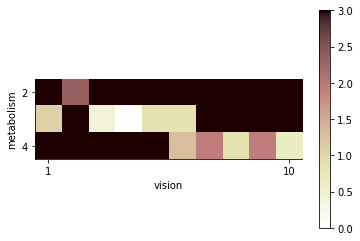

In [1]:
%matplotlib inline
from itertools import product
from time import strftime

from sugarscape_cg.model import SugarscapeCg

import history_matching
import sugarscape_hm

def run_simulation(x):
    SS = SugarscapeCg(height=30, width=75, max_metabolism=x[0], max_vision=x[1])
    SS.verbose = False
    y =  SS.run_model(step_count=50)
    return y

history_matching.y = 67
history_matching.f = run_simulation

plaus_metabolism = range(1, 7)
plaus_vision = range(1, 11)
plaus_space = []  # not yet explored
new_plaus_space = list(product(plaus_metabolism, plaus_vision))

while not history_matching.is_all_plausible(plaus_space, new_plaus_space):
    plaus_space = new_plaus_space
    new_plaus_space, implaus_scores = history_matching.wave(plaus_space)
    sugarscape_hm.plot_implaus_2d(plaus_space, implaus_scores, ('vision','metabolism'))

The metabolism has converged onto values of 3 and 4 being plausible. Vision has stayed uncertain as before, though we do see the correlation between high metabolism and high vision again (which we did not get in the small environment).

Given the results are consistent as the environment changes, does this increase our confidence in the results and in the model? If the model were poorly designed, would the history matching results have fluctuated more?

# Does a bad model fail to converge?

Let's say our agents aren't smart. They can see where the best food is, but they don't necessarily go there. Their vision dicates how far they can move, but they're no longer picking the neighbouring space with the most sugar - they're picking a random space. To do this, the module agents.py was changed so that the agent's movement is given by self.random.choice(neighbors).

Given the model is no longer a good representation of the "real world", we expect we'll fail to find a plausible space. In this example, only maximum vision is tested for plausibility.

In [1]:
import numpy as np

from sugarscape_cg.model import SugarscapeCg

import history_matching
import sugarscape_hm

In [2]:
def run_simulation(x):
    SS = SugarscapeCg(max_vision=x)
    SS.verbose = False
    y =  SS.run_model(step_count=50)
    return y

In [3]:
history_matching.y = 63  # the real world observation
history_matching.f = run_simulation  # the function (simulation) used for history matching

def run_history_matching(new_plaus_space):
    plaus_space = []  # not yet explored
    while (len(new_plaus_space) > 0 and not history_matching.is_all_plausible(plaus_space, new_plaus_space)):
        plaus_space = new_plaus_space
        new_plaus_space, implaus_scores = history_matching.wave(plaus_space)
        sugarscape_hm.plot_implaus_1d(plaus_space, implaus_scores)
    print('Finished with', str(new_plaus_space))

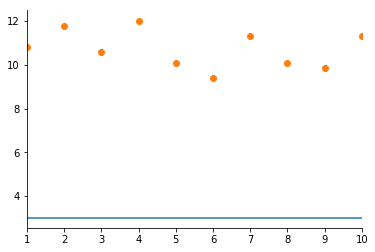

Finished with []


In [4]:
# initial plausible space to explore
# note that SugarscapeCg only takes integer values for vision
plaus_space = np.array(range(1, 11))
run_history_matching(plaus_space)

Every value of maximum vision tested is found to be implausible. This demonstrates that an implausibile result is not necessarily due to an implausible value, but may instead be caused by a poorly designed model.